# PREDICTING FUTURE AVOCADO PRICES USING FACEBOOK PROPHET

# Work Description

In this project, we will predict the future prices of Avocado based on historical data and using Facebook Prophet.
- [Facebook Prophet](https://facebook.github.io/prophet/) is an open source tool used for time serie forcasting
- We will be comparing a univariate to a multi-variate approach for price prediction.

**The description of the dataset :**

- Date: The date of the observation
- AveragePrice: the average price of a single avocado
- type: conventional or organic
- year: the year
- Region: the city or region of the observation
- Total Volume: Total number of avocados sold
- 4046: Total number of avocados with PLU 4046 sold
- 4225: Total number of avocados with PLU 4225 sold
- 4770: Total number of avocados with PLU 4770 sold

In [74]:
#Installing the python libraries using the file 'requirements.txt'. This command will install a lighweighted version of FB Prophet 
!pip install -r requirements.txt --no-cache-dir

In [4]:
#Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from prophet import Prophet
from sklearn.preprocessing import LabelBinarizer , LabelEncoder
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error

sns.set_theme(style="whitegrid", palette="Set2")
%matplotlib inline

# TASK 1 : Reading the data and understanding it

In [5]:
# Reading the dataset from the Google Collab directory (the file must be uploaded first)
data = pd.read_csv('./data/avocado.csv')

In [6]:
# Let's view the head of the training dataset
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [7]:
# Let's view the last elements in the training dataset
data.tail()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
18248,11,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


The 'Date' type must be changed, no obvious missing data. There is some categorical features : region, type

In [9]:
data.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [10]:
data.describe(include='object')

,Date,type,region
count,18249,18249,18249
unique,169,2,54
top,2015-12-27,conventional,Albany
freq,108,9126,338


There is two types of Avocado in this dataset as mentionned in this notebook introduction. The sells are recorded across 54 regions or city in the USA. The is 168 unique dates which means that multiple observations are recorded at the same date. We fill further inspect the data distribution in the following section

In [11]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

No missing data

# TASK #2: EXPLORE THE DATASET



In [12]:
#Convert the date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    18249 non-null  int64         
 1   Date          18249 non-null  datetime64[ns]
 2   AveragePrice  18249 non-null  float64       
 3   Total Volume  18249 non-null  float64       
 4   4046          18249 non-null  float64       
 5   4225          18249 non-null  float64       
 6   4770          18249 non-null  float64       
 7   Total Bags    18249 non-null  float64       
 8   Small Bags    18249 non-null  float64       
 9   Large Bags    18249 non-null  float64       
 10  XLarge Bags   18249 non-null  float64       
 11  type          18249 non-null  object        
 12  year          18249 non-null  int64         
 13  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.9+ MB


In [14]:
#set the date as the index
data.set_index('Date', inplace=True)

In [15]:
sorted=data.sort_index(ascending=True)
sorted.head(10)

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-01-04,51,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast
2015-01-04,51,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,2015,Chicago
2015-01-04,51,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton
2015-01-04,51,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh
2015-01-04,51,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,2015,Boise
2015-01-04,51,0.75,758118.95,426878.87,147958.43,15267.89,168013.76,165202.22,2811.54,0.00,conventional,2015,WestTexNewMexico
2015-01-04,51,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,2015,LosAngeles
2015-01-04,51,1.50,6329.83,3730.80,2141.91,0.00,457.12,426.67,30.45,0.00,organic,2015,LasVegas
2015-01-04,51,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta


We can notice that the 'dates' are repeated multiple consecutive times. We should further inspect this point to understand how to observations are recorded in the dataset.




In [16]:
#Find the unique of values of 'Dates' and sort them
dates=sorted.index.value_counts().reset_index().sort_values('Date')
dates

,Date,count
0,2015-01-04,108
42,2015-01-11,108
107,2015-01-18,108
108,2015-01-25,108
109,2015-02-01,108
...,...,...
57,2018-02-25,108
58,2018-03-04,108
59,2018-03-11,108
60,2018-03-18,108


We can observe a 7-day gap between consecutive dates. This suggests that the avocado sales data are recorded on a weekly basis in this dataset.

In [17]:
#we will check if the previous observation is correct
# Create a column that shifts the dates by one row : go forward by 1 step
dates['next_date'] = dates['Date'].shift(-1)
dates

,Date,count,next_date
0,2015-01-04,108,2015-01-11
42,2015-01-11,108,2015-01-18
107,2015-01-18,108,2015-01-25
108,2015-01-25,108,2015-02-01
109,2015-02-01,108,2015-02-08
...,...,...,...
57,2018-02-25,108,2018-03-04
58,2018-03-04,108,2018-03-11
59,2018-03-11,108,2018-03-18
60,2018-03-18,108,2018-03-25


In [18]:
dates['date_diff'] = dates['next_date'] - dates['Date']
dates['date_diff'].value_counts().reset_index()

,date_diff,count
0,7 days,168


**By running the pervious code, we are able to confirm that the prices' observations are recorded each week**

In [19]:
grouped=sorted.groupby(['region', 'type', 'Date' ]).first()
grouped.head(10)

Unnamed: 0  AveragePrice  Total Volume  \
region type         Date                                                 
Albany conventional 2015-01-04          51          1.22      40873.28   
                    2015-01-11          50          1.24      41195.08   
                    2015-01-18          49          1.17      44511.28   
                    2015-01-25          48          1.06      45147.50   
                    2015-02-01          47          0.99      70873.60   
                    2015-02-08          46          0.99      51253.97   
                    2015-02-15          45          1.06      41567.62   
                    2015-02-22          44          1.07      45675.05   
                    2015-03-01          43          0.99      55595.74   
                    2015-03-08          42          1.07      40507.36   

                                   4046      4225    4770  Total Bags  \
region type         Date                                                
Albany conventional 2015-01-04  2819.50  28287.42   49.90     9716.46   
                    2015-01-11  1002.85  31640.34  127.12     8424.77   
                    2015-01-18   914.14  31540.32  135.77    11921.05   
                    2015-01-25   941.38  33196.16  164.14    10845.82   
                    2015-02-01  1353.90  60017.20  179.32     9323.18   
                    2015-02-08  1357.37  39111.81  163.25    10621.54   
                    2015-02-15   986.66  30045.51  222.42    10313.03   
                    2015-02-22  1088.38  35056.13  151.00     9379.54   
                    2015-03-01   629.46  45633.34  181.49     9151.45   
                    2015-03-08   795.68  30370.64  159.05     9181.99   

                                Small Bags  Large Bags  XLarge Bags  year  
region type         Date                                                   
Albany conventional 2015-01-04     9186.93      529.53          0.0  2015  
                    2015-01-11     8036.04      388.73          0.0  2015  
                    2015-01-18    11651.09      269.96          0.0  2015  
                    2015-01-25    10103.35      742.47          0.0  2015  
                    2015-02-01     9170.82      152.36          0.0  2015  
                    2015-02-08    10113.10      508.44          0.0  2015  
                    2015-02-15     9979.87      333.16          0.0  2015  
                    2015-02-22     9000.16      379.38          0.0  2015  
                    2015-03-01     8986.06      165.39          0.0  2015  
                    2015-03-08     8827.55      354.44          0.0  2015

Furthermore, the observations in the dataset are saved each week for each type of avocado ('organic', 'conventionnal') and for each region (58 different region). This is how the obsevations in this dataset are organized.

## Univariate analysis

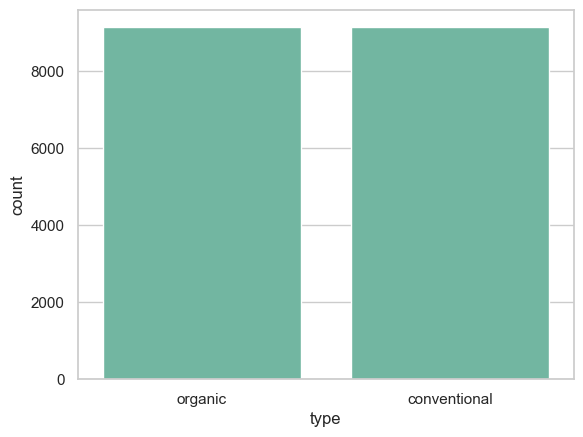

In [20]:
sns.countplot(x='type', data=sorted)
plt.show()

The two types of Avocado are equally represented in the dataset.

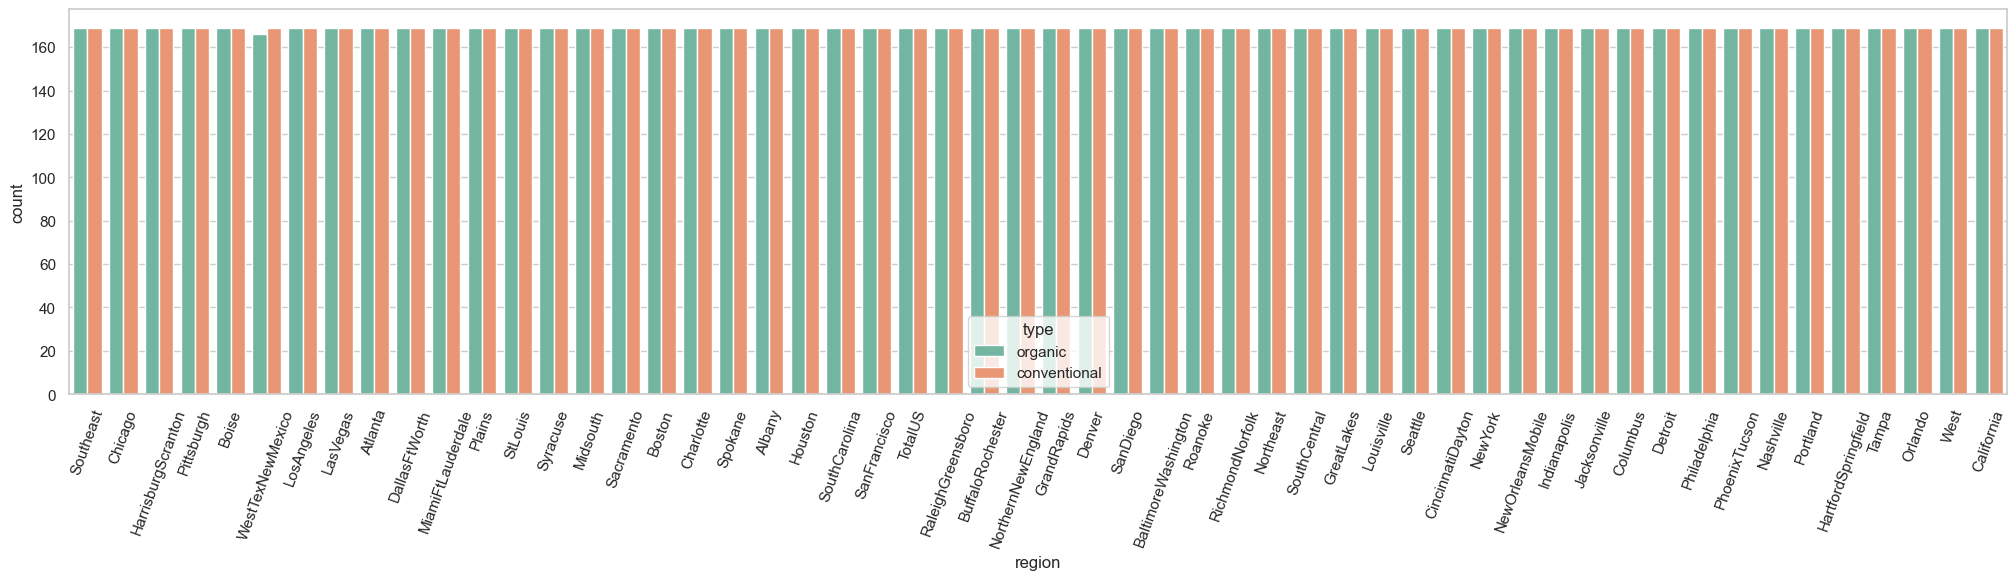

In [21]:
plt.figure(figsize=(25,5))
sns.countplot(x='region', hue='type', data=sorted)
plt.tick_params(axis='x', rotation=70)
plt.show()

Similarly, the observations are equally distributed across the regions and for each type

* Distribution of AveragePrice values per avocado type

<Figure size 1000x600 with 0 Axes>

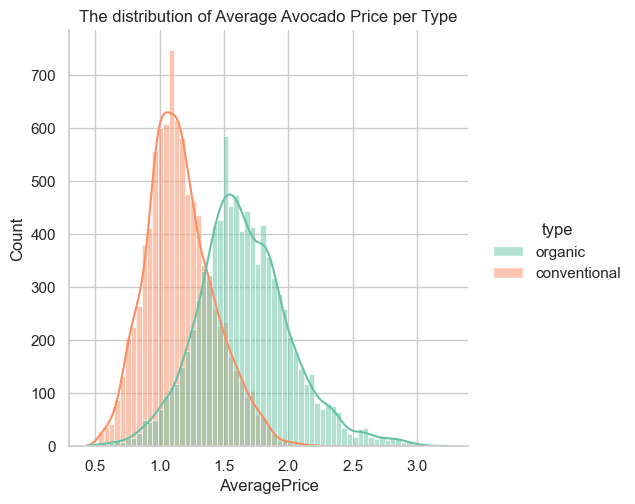

In [22]:
# Plot distribution of the average price
plt.figure(figsize=(10, 6))
sns.displot(x='AveragePrice', color='r', kde=True, hue='type', data=sorted)
plt.title("The distribution of Average Avocado Price per Type")
plt.show()

From the above distribution plot of the average avocado price by type, we can observe the following:

1. **Conventional Avocados**:
   - The distribution of the average price for conventional avocados is almost Gaussian.
   - The prices range from approximately $0.50 to $2.00.
   - The average price is centered around $1.00, indicating that most conventional avocados are sold at this price.
   - There is a slight skewness toward higher prices, particularly between $1.50 and $2.00, but this skewness is minimal.

2. **Organic Avocados**:
   - The distribution of the average price for organic avocados is also somewhat Gaussian, but with a noticeable right skew.
   - The prices range from approximately $1.00 to $3.00.
   - The average price is centered around $1.50, which is higher than that of conventional avocados.
   - The distribution has a longer tail towards higher prices, indicating that organic avocados can reach prices up to $3.00.

In orverall,  prganic avocados generally have higher average prices compared to conventional avocados. Conventional avocados have a more tightly clustered price distribution centered around $1.00 with minimal skewness, while organic avocados show a broader price range with a higher center and more significant skewness towards higher prices. This indicates that organic avocados are generally more expensive and have a wider variation in price compared to conventional avocados.Both distributions exhibit a degree of skewness toward higher prices, but this is more pronounced in organic avocados.

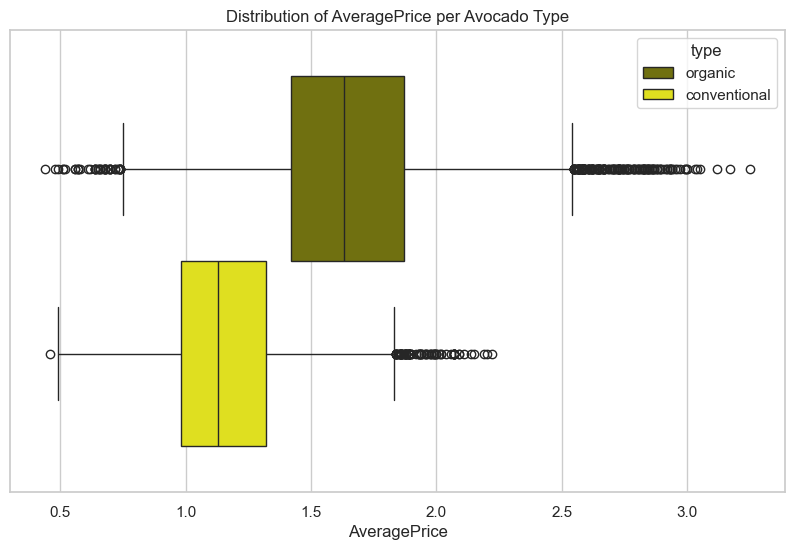

In [23]:
# Plot a violin plot of the average price vs. avocado type
plt.figure(figsize=(10, 6))
sns.boxplot(x='AveragePrice', hue='type', data=sorted, palette=['Olive', 'Yellow'])
plt.title('Distribution of AveragePrice per Avocado Type')
plt.show()

**Observations**: From the boxplot of the average avocado price by type, several additional conclusions can be drawn:

 * **Median Price**: The median price of organic avocados is significantly higher than that of conventional avocados. The median for organic avocados is around $1.75, while for conventional avocados, it is around $1.10.

* **Interquartile Range (IQR)**: The IQR, which represents the middle 50% of the data, is wider for organic avocados compared to conventional avocados. This indicates a greater variability in the average prices of organic avocados. For organic avocados, the IQR ranges approximately from $1.40 to $2.00. For conventional avocados, the IQR ranges approximately from $0.90 to $1.25.
* **Outliers**: Both types of avocados have outliers, but the range and frequency of these outliers differ. Conventional avocados have numerous lower outliers below $0.80 and a few higher outliers above $1.50. Organic avocados also have several lower outliers below $1.20 and higher outliers above $2.50.
* **Whiskers**: The whiskers of the boxplot, which represent the range of the data excluding outliers, show that organic avocados have a higher overall price range. For conventional avocados, the whiskers extend from approximately $0.60 to $1.50. For organic avocados, the whiskers extend from approximately $1.20 to $2.50.
* **Symmetry and Skewness**: The boxplot of conventional avocados shows a slight right skewness, indicated by a longer whisker on the higher price end. The boxplot of organic avocados also shows right skewness, but it is less pronounced due to a more symmetric distribution around the median.

Overall, the boxplot emphasizes the higher cost and greater price variability of organic avocados compared to conventional avocados.


#### **Average price distribution per date and per type**


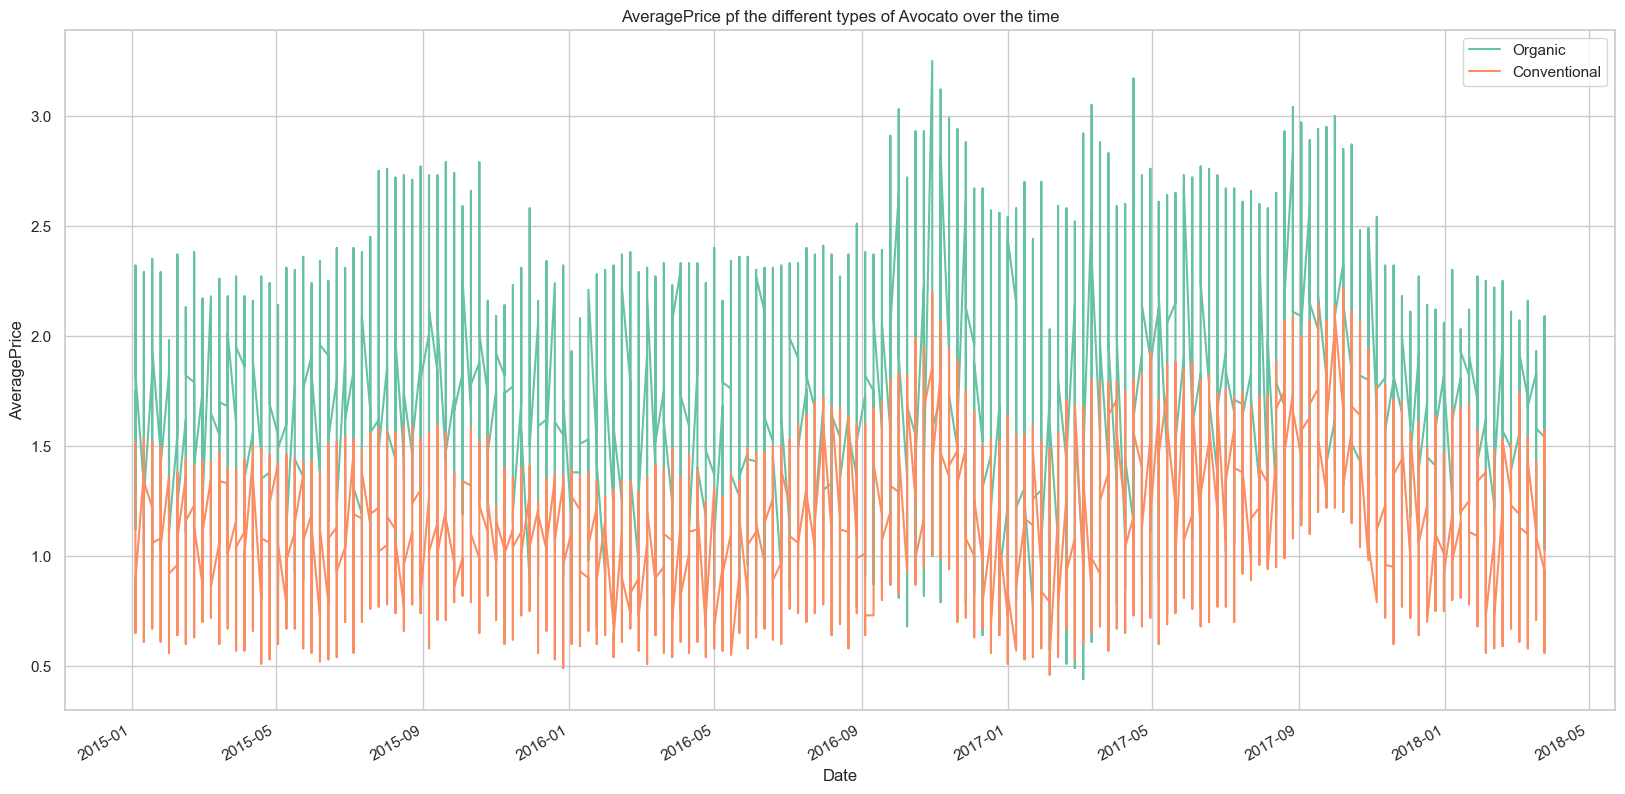

In [24]:
plt.figure(figsize=(20, 10))
sorted[sorted['type']=='organic']['AveragePrice'].plot(label="Organic")
sorted[sorted['type']=='conventional']['AveragePrice'].plot(label = "Conventional")
plt.ylabel('AveragePrice')
plt.title("AveragePrice pf the different types of Avocato over the time")
plt.legend()
plt.show()

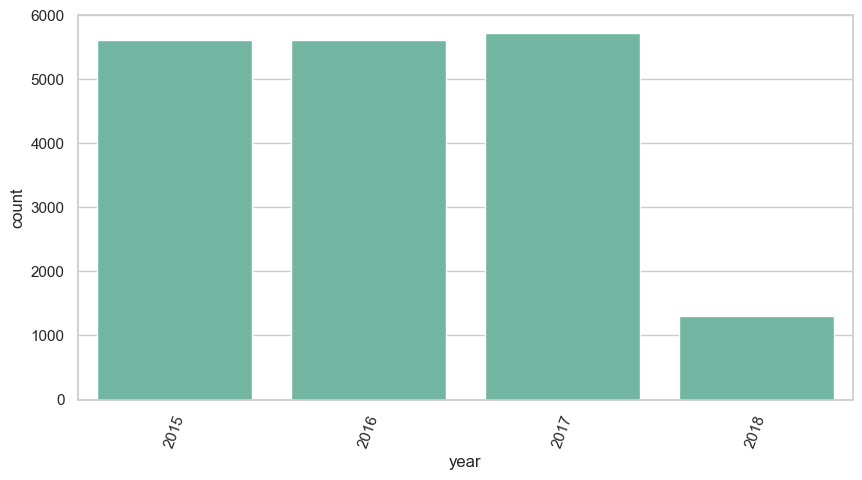

In [25]:
# Bar Chart to indicate the count in every year
plt.figure(figsize=(10,5))
sns.countplot(x = 'year', data = sorted)
plt.tick_params(axis='x', rotation=70)
plt.show()

We can observe that there is an equal number of observations distributed over the first 3 years (2015,2015,2017). However, there is a significantly limited number of observations recorded for the year 2018.

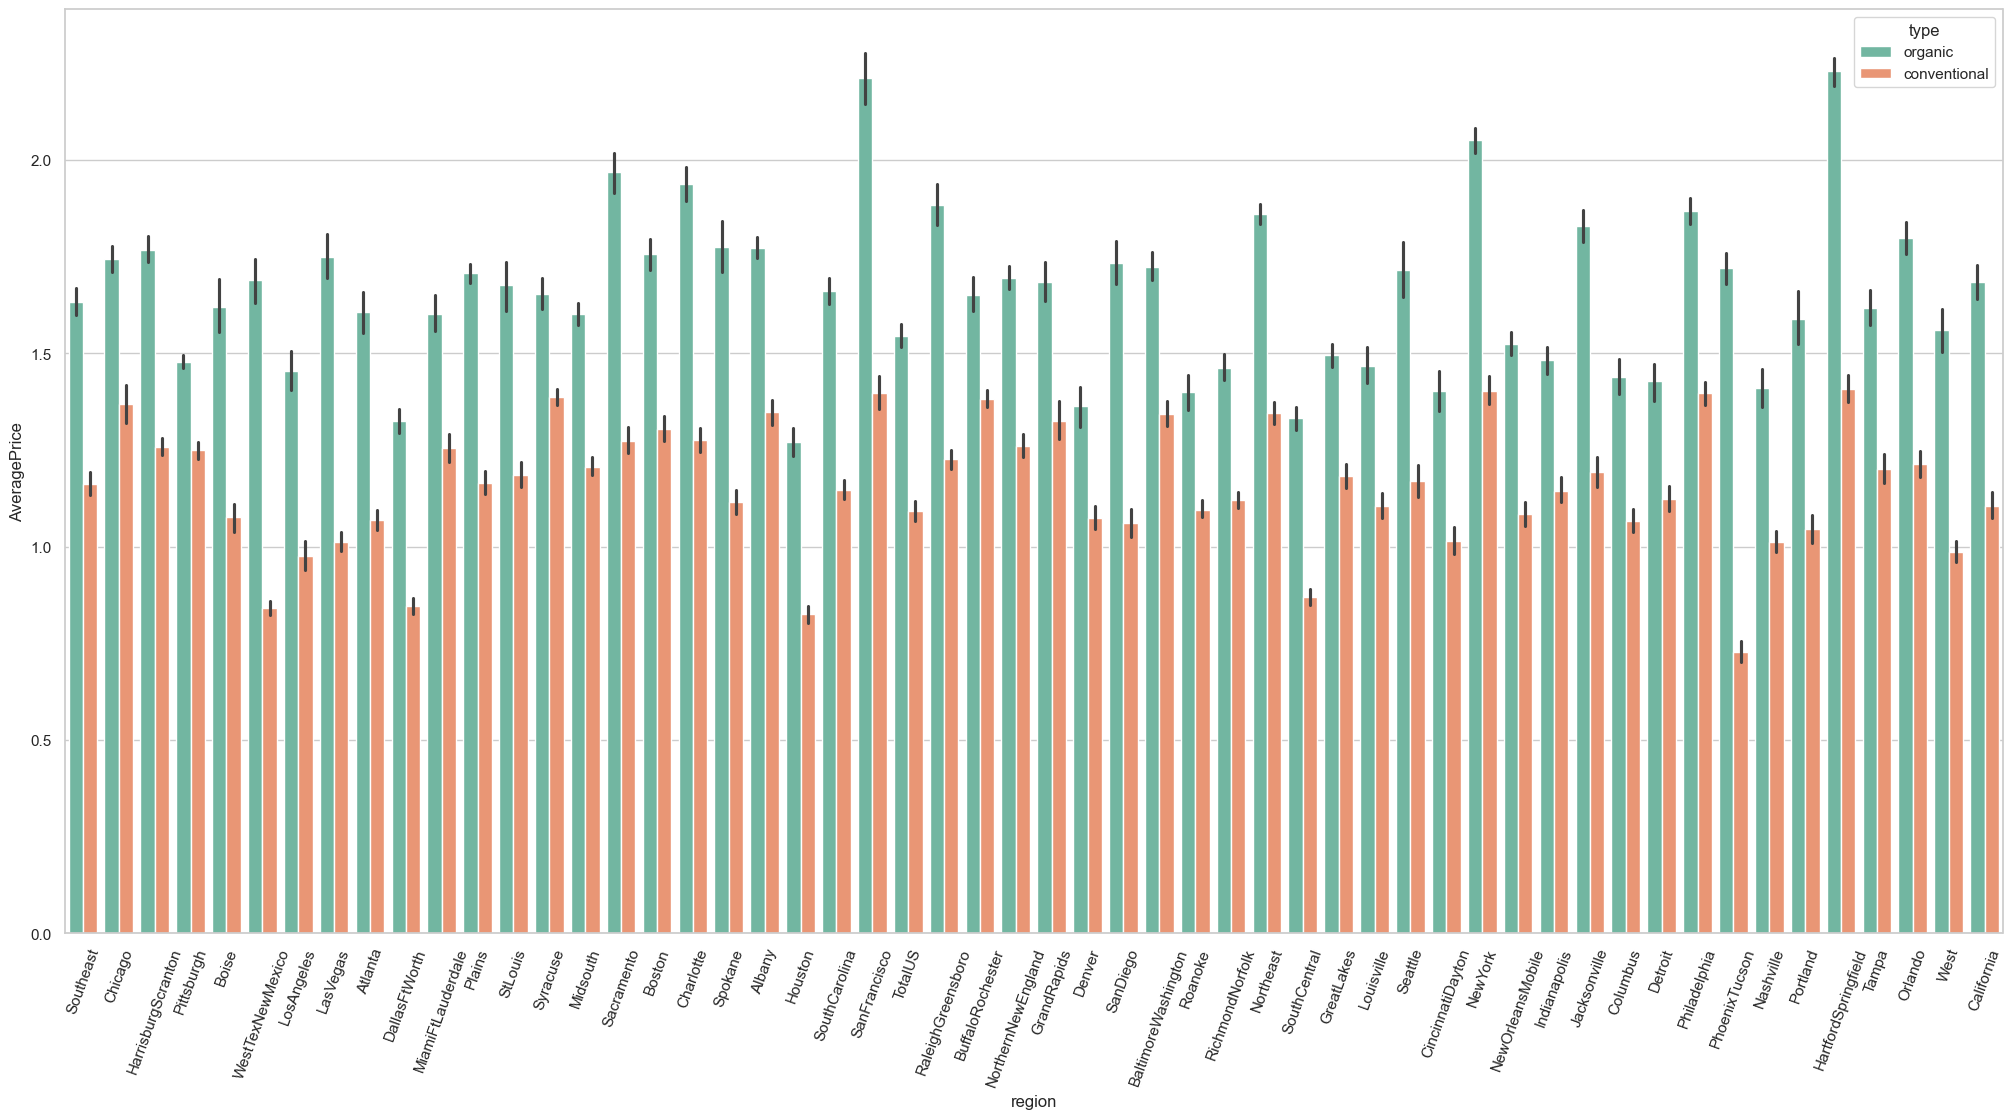

In [26]:
 # plot the avocado prices per regions for each type of avocados
plt.figure(figsize=[25,12])
sns.barplot(data=sorted, x='region', y='AveragePrice', hue='type')
plt.tick_params(axis='x', rotation=70)
plt.show()

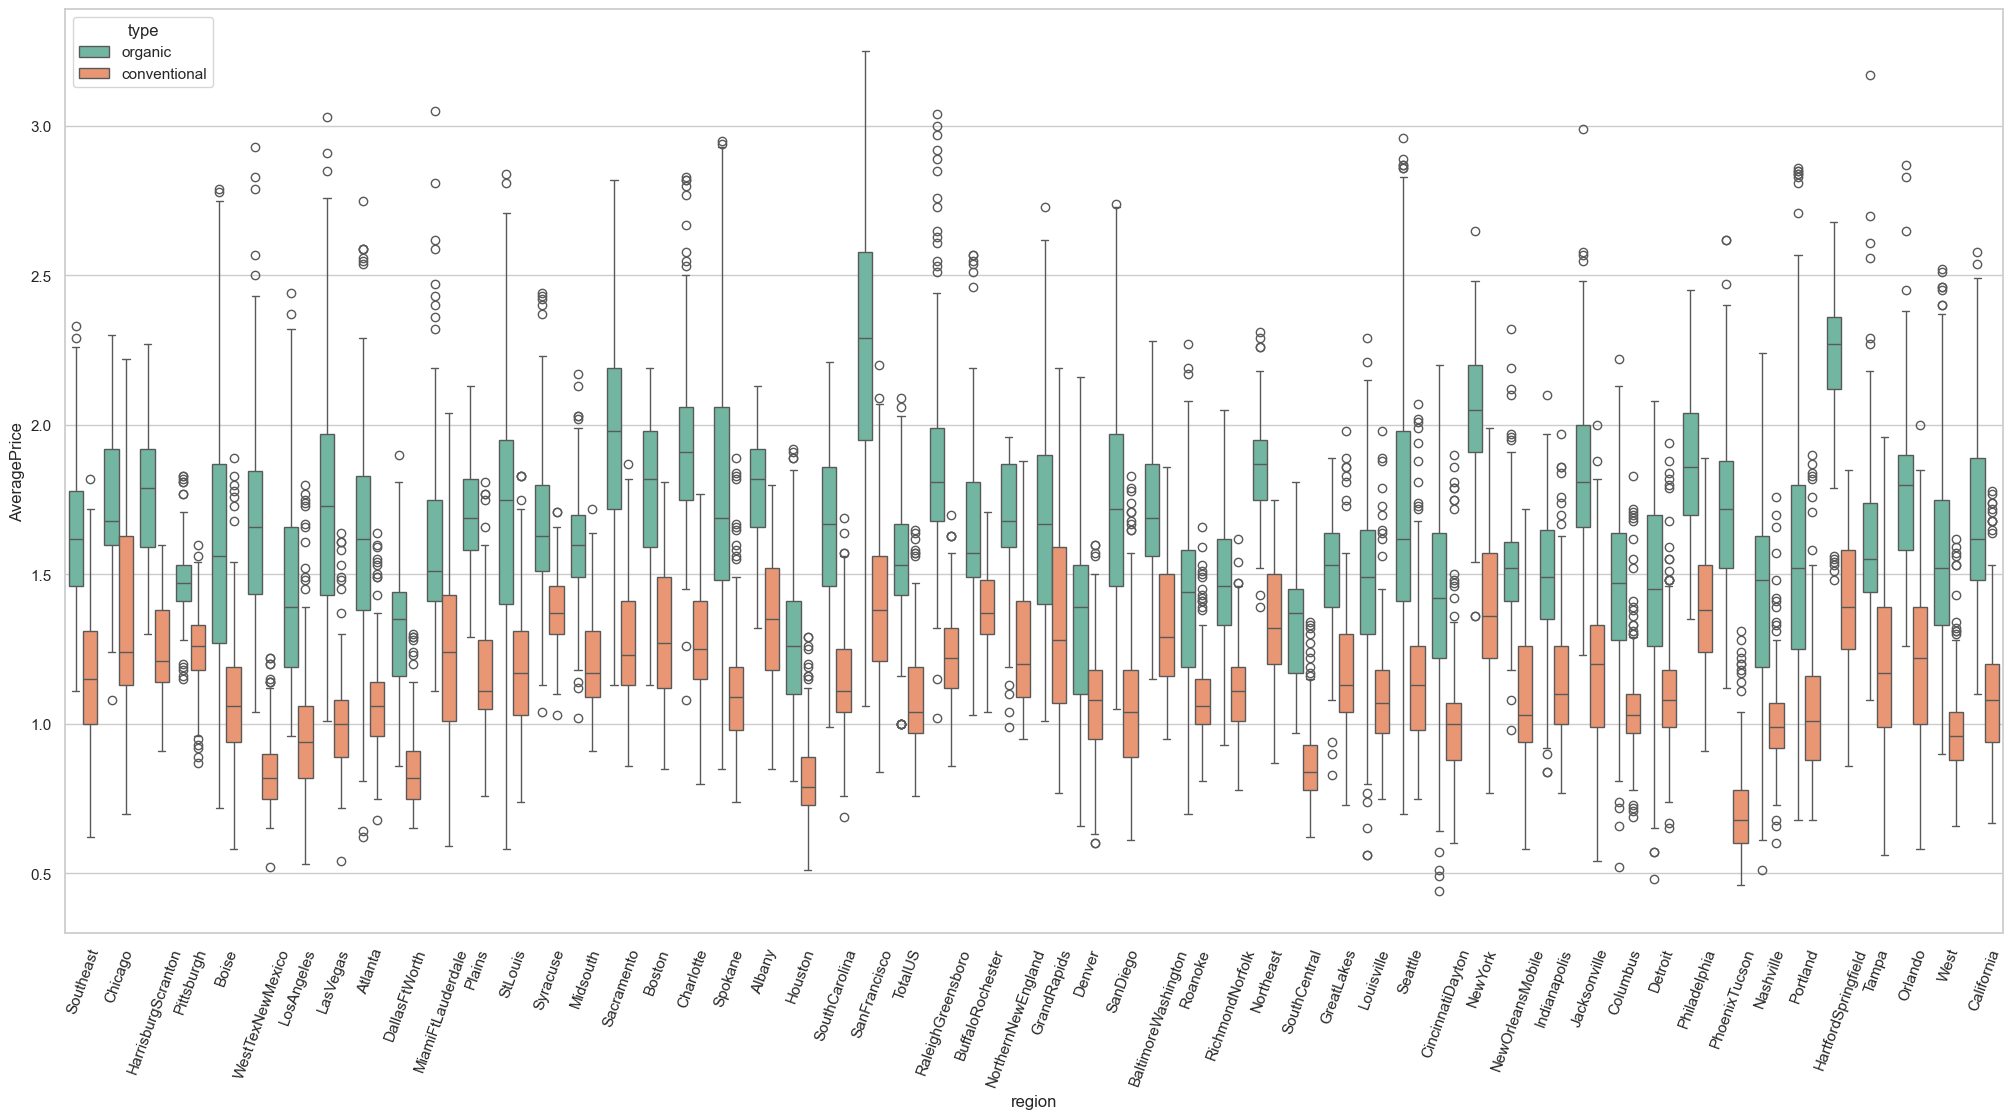

In [27]:
 # plot the avocado prices vs. regions for each type of avocados
plt.figure(figsize=[25,12])
sns.boxplot(data=sorted, x='region', y='AveragePrice', hue='type')
plt.tick_params(axis='x', rotation=70)
plt.show()

The average price of avocados varies significantly across different regions and types. For example, the mean price of conventional avocados is about $0.75 in South Central, while it is around $1.25 in Chicago. Similarly, there are substantial regional differences in the average price of organic avocados. In Houston, the mean price is about $1.25, whereas in San Francisco, it reaches $2.25. Overall, organic avocados consistently cost more than conventional ones in all regions. The distribution of average prices exhibits diverse patterns across regions, making it difficult to identify a uniform trend in price evolution by region and type.

#### Conclusions

The observed regional and type-based variations in the average price of avocados can significantly impact the modeling of a time series to predict avocado prices. Here are some potential impacts :

1. **Regional Differences**:
   - The significant price differences across regions suggest that a single global model may not be suitable.
   - It may be necessary to build separate models for each region or include region as a feature in a unified model.

2. **Type-Based Variations**:
   - The consistent price difference between organic and conventional avocados indicates the need to model each type separately or to include type as a feature.
   
3. **Complexity in Pattern Recognition**:
   - The diverse patterns in price distribution across regions imply that price trends and seasonality might differ significantly from one region to another.
   - This complexity must be accounted for in the modeling process to avoid overgeneralization.

**Next steps**
- Data Segmentation: We decided to segment the data by region and avocado type for a better handling of price variation patterns. Rather than building a single global model to predict the avocado price, we will train a separate models for each region and for each type of avocado.
- After the segmentation, we will conduct a trend analysis by plotting and analyze price trends over time for the a chosen region and avocado type.

# TASK 3 : Data segmentation and analysis

Filtering the data by region and type and study the prices trends and saisonal patterns.

**We choose to focus of the time series data of avocado sales in the "West" region.**


In [38]:
#Filtering the data by region and maintain only the madatory columns
west_df = sorted[sorted['region']=='West'][['AveragePrice', 'Total Volume', 'type', 'year']].copy()

In [39]:
west_df.head(10)

,AveragePrice,Total Volume,type,year
Date,,,,
2015-01-04,1.40,187548.30,organic,2015
2015-01-04,0.89,5794410.58,conventional,2015
2015-01-11,1.39,223156.55,organic,2015
2015-01-11,0.95,5333097.71,conventional,2015
2015-01-18,0.96,5475363.01,conventional,2015
2015-01-18,1.33,251749.94,organic,2015
2015-01-25,0.94,5461313.90,conventional,2015
2015-01-25,1.52,166494.38,organic,2015
2015-02-01,0.84,8362504.08,conventional,2015


In [40]:
west_org= west_df[west_df['type']=='organic']
west_conv= west_df[west_df['type']=='conventional']

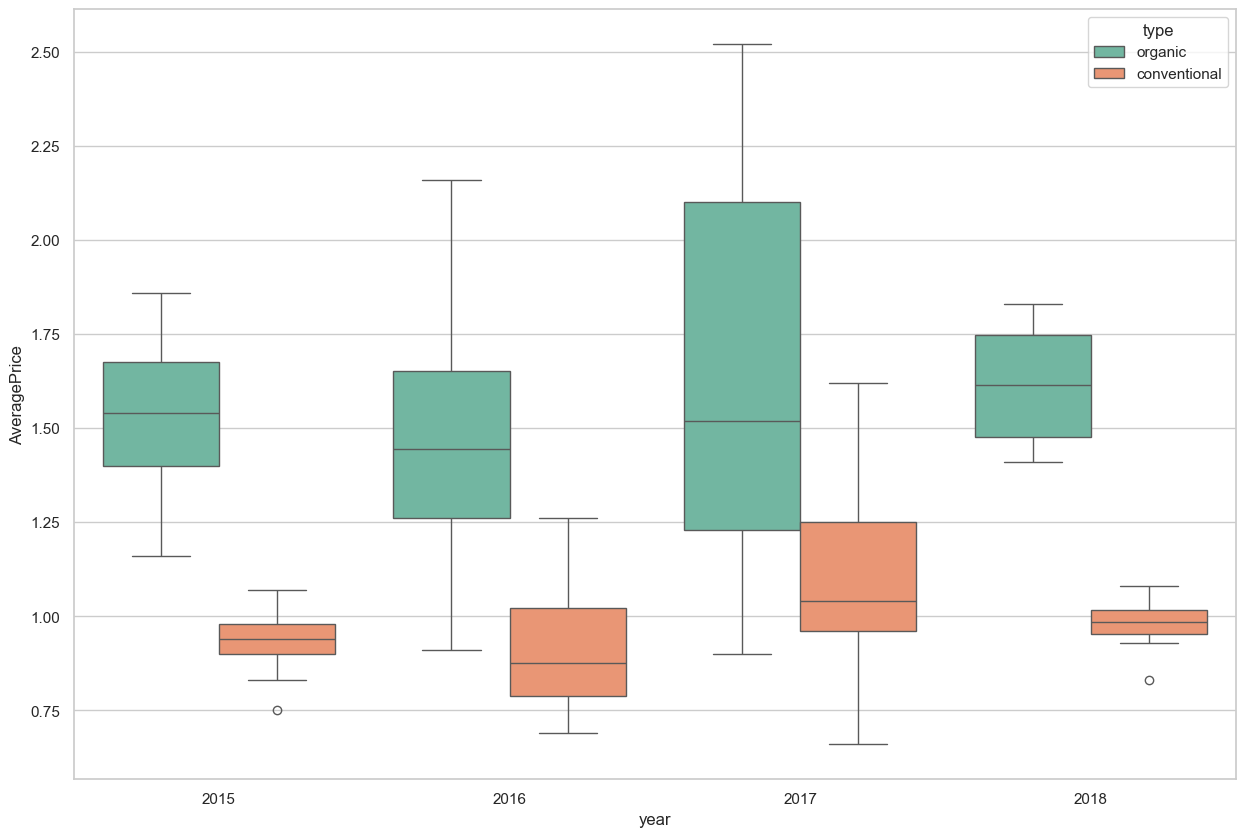

In [46]:
plt.figure(figsize=(15, 10))
sns.boxplot(x=west_df['year'], y = west_df['AveragePrice'], data=west_df, hue='type')
plt.show()

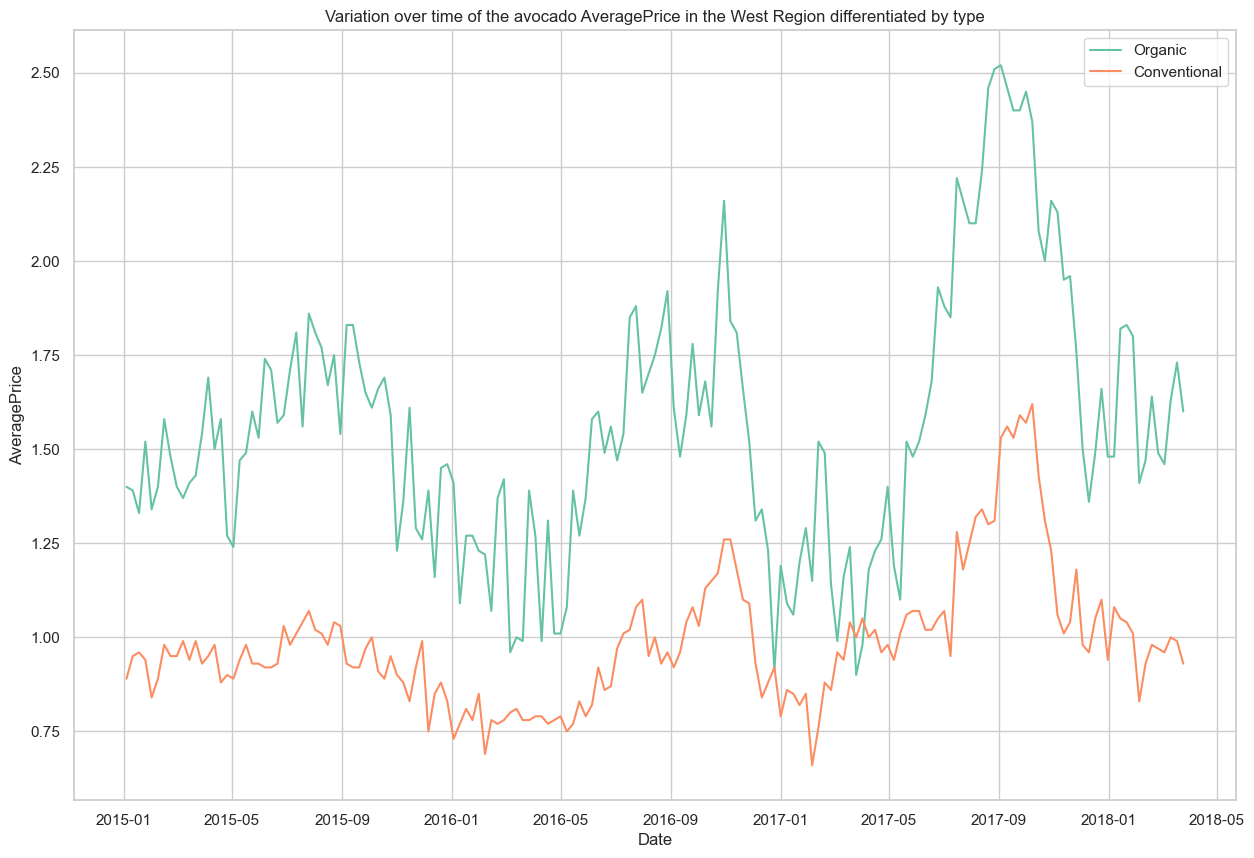

In [47]:
plt.figure(figsize=(15, 10))
sns.lineplot(x=west_org.index, y = west_org['AveragePrice'], label="Organic")
sns.lineplot(x=west_conv.index, y = west_conv['AveragePrice'], label="Conventional")
plt.title('Variation over time of the avocado AveragePrice in the West Region differentiated by type')
plt.show()

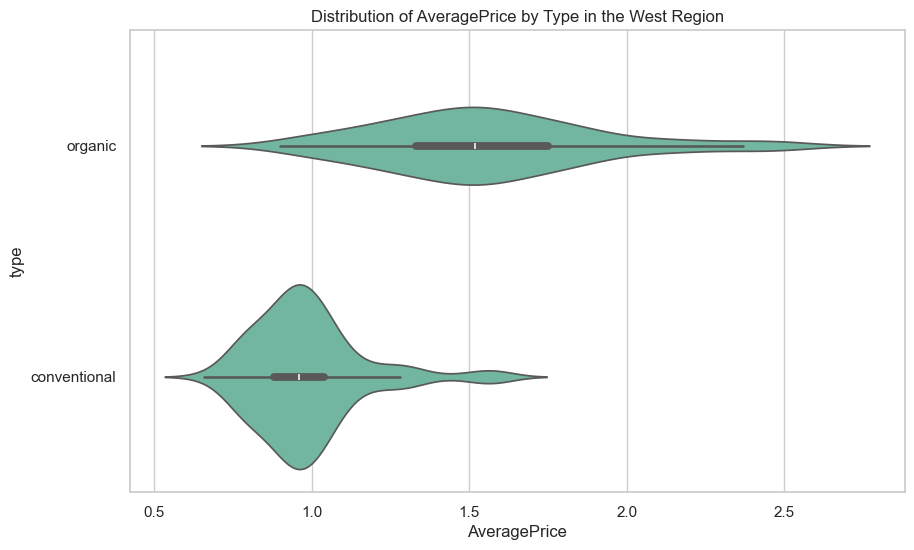

In [49]:
# Plot a violin plot of the average price vs. avocado type
plt.figure(figsize=(10, 6))
sns.violinplot(x='AveragePrice', y= 'type', data=west_df )
plt.title('Distribution of AveragePrice by Type in the West Region')
plt.show()

From the above plots, we can draw the following conclusions :

1. **Organic Avocados**:
   - **Initial Period (2015)**: Prices start around $1.50 and rise to about $1.75 by mid-2015.
   - **Mid-2015 to End of 2016**: There is a notable drop in prices at the beginning of 2016, followed by a period of fluctuations between $1.25 and $1.75.
   - **2017**: Prices peak around $2.25, with significant volatility.
   - **End of 2017 to 2018**: A sharp decline in prices around the end of 2017, followed by a recovery and further fluctuations.

2. **Conventional Avocados**:
   - **Initial Period (2015)**: Prices remain relatively stable around $0.90 to $1.00.
   - **2016**: A gradual decline to around $0.75 by the end of the year.
   - **2017**: Prices fluctuate with a peak around mid-2017 reaching just over $1.00.
   - **End of 2017 to 2018**: Prices experience a decline followed by minor fluctuations around $0.75 to $1.00.

In overall, we can notice that organic avocados consistently have higher average prices compared to conventional avocados throughout the entire time period. Both organic and conventional avocados show periodic fluctuations in price, indicating potential seasonality in the avocado market. By comparing these fluctuaction, we can notice that 

- **Price Volatility**: Organic avocado prices are more volatile compared to conventional avocado prices. This is evident from the larger swings and higher peaks.
- **Price Peaks**: Both types of avocados have distinct peak periods, but organic avocados reach much higher prices than conventional ones.
- **General Decline**: Both types show a general decline in prices towards the end of the period, particularly noticeable in late 2017 for organic avocados.

### Interpretation for Time Series Modeling
- **Separate Modeling**: Given the distinct price behaviors and levels, it would be beneficial to model the prices of organic and conventional avocados separately.
- **Seasonality**: The periodic fluctuations suggest that incorporating seasonality into the model could improve accuracy.
- **External Factors**: The volatility in prices, especially for organic avocados, indicates that external factors (e.g., supply chain issues, weather events) might play a significant role and should be considered if possible.

### Next Steps in Analysis
1. **Seasonality Analysis**: Decompose the time series to better understand the seasonal components.
2. **External Factors**: Investigate external factors that could influence price volatility.
3. **Modeling Approach**:
   - Separate models for organic and conventional avocados.
   - Include seasonality and potential external factors in the model.

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

# For organic avocados
result_org = seasonal_decompose(west_org['AveragePrice'], model='multiplicative', period=52)  #since it is weekly data

# For conventional avocados
result_conv = seasonal_decompose(west_conv['AveragePrice'], model='multiplicative', period=52)  #since it is weekly data

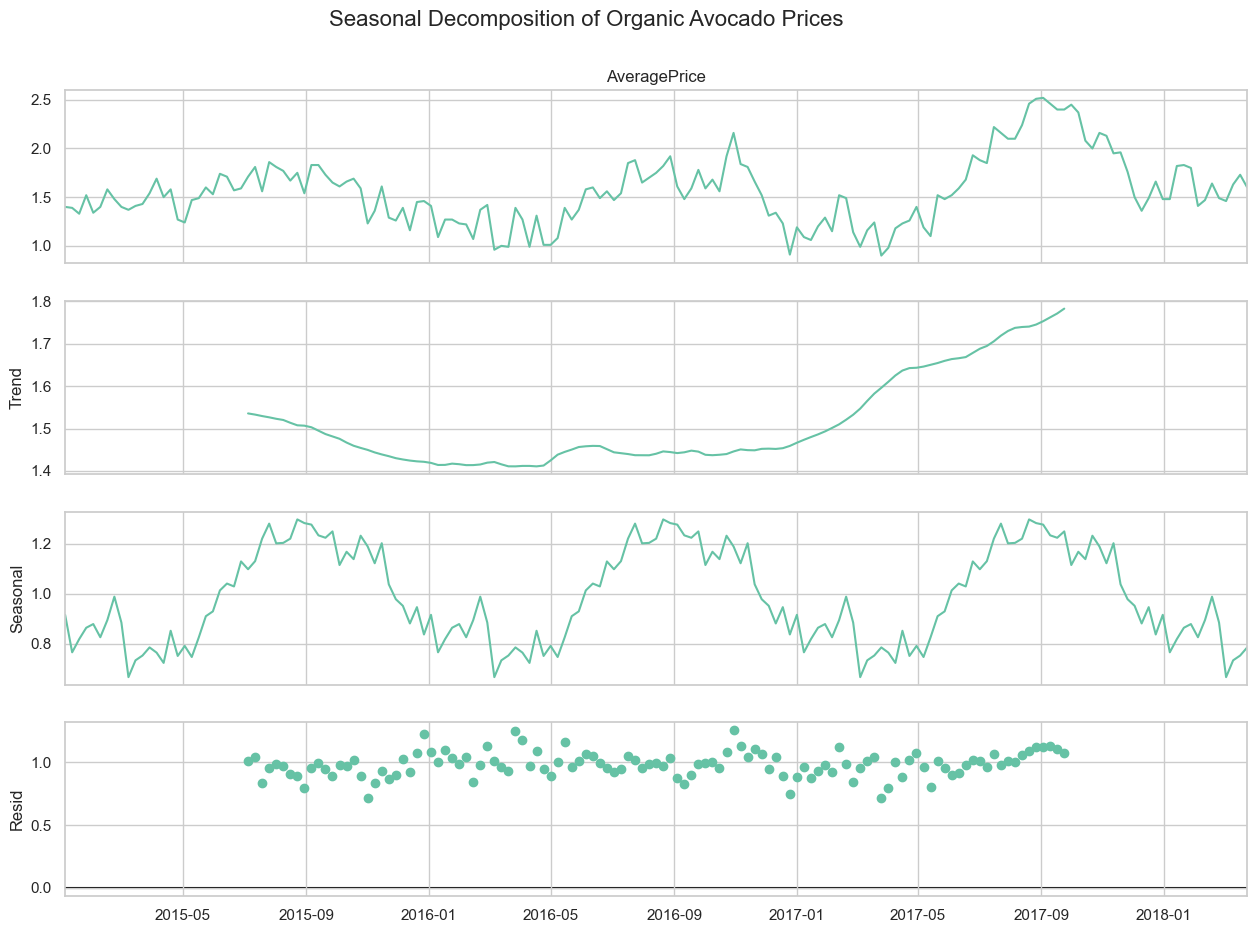

In [59]:
#Plotting the seasonal decomposition of Organic avocado prices
fig = result_org.plot()
# Adjust figure size
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition of Organic Avocado Prices', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

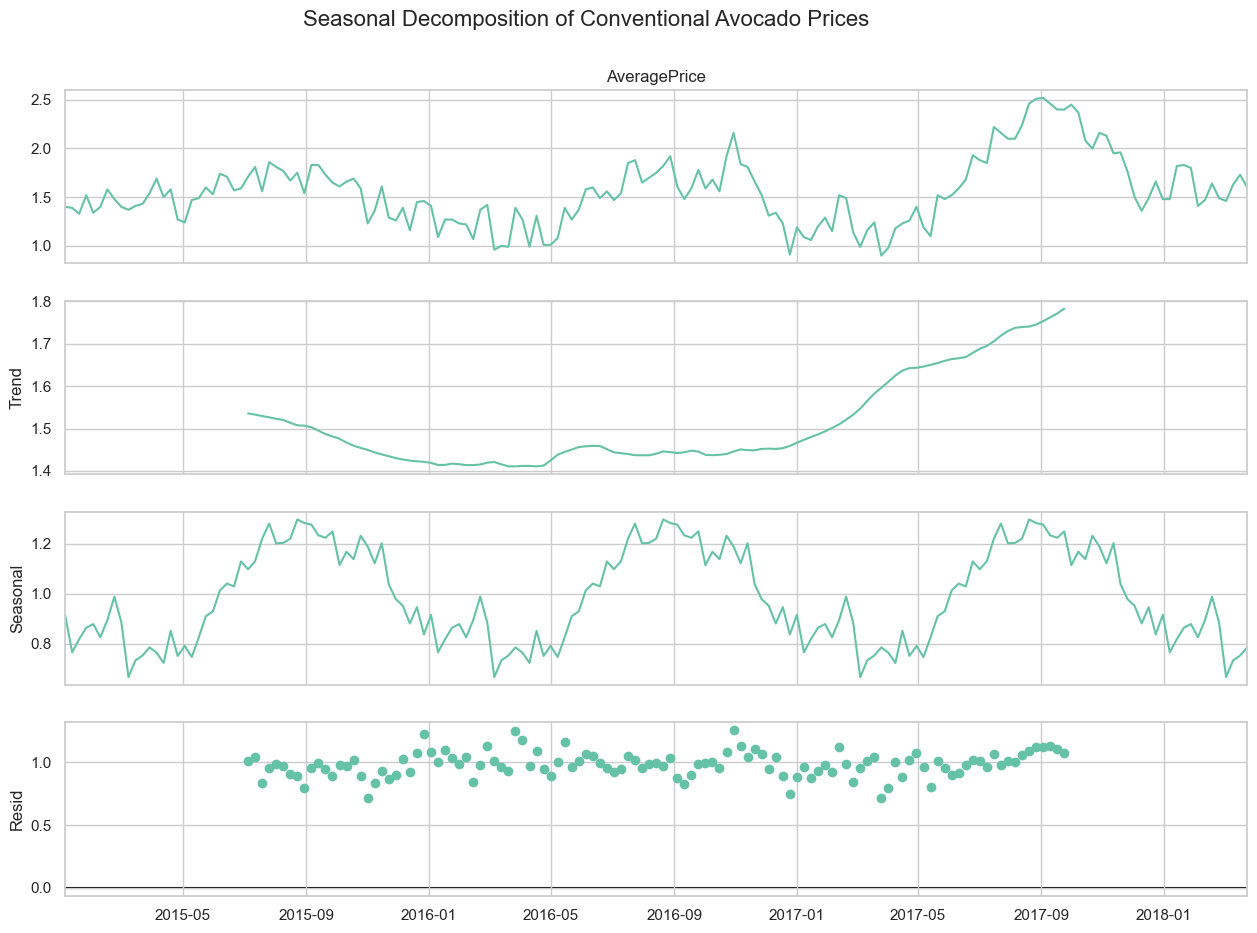

In [60]:
#Plotting the seasonal decomposition of Conventional avocado prices
fig = result_org.plot()
# Adjust figure size
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition of Conventional Avocado Prices', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# TASK 4: Preparing the data for the training with FB Prophet

* Rename the columns to work with Prophet : date => ds, AveragePrice(target) => y


In [ ]:
west_df.reset_index(inplace=True)
data_prophet = west_df.drop(['year'], axis=1)
data_prophet= data_prophet.rename(columns={'Date':'ds', 'AveragePrice':'y', 'Total Volume': 'TotalVolume'})
data_prophet.head()

,ds,y,TotalVolume,type
0,2015-01-04,1.40,187548.30,organic
1,2015-01-04,0.89,5794410.58,conventional
2,2015-01-11,1.39,223156.55,organic
3,2015-01-11,0.95,5333097.71,conventional
4,2015-01-18,0.96,5475363.01,conventional


In [ ]:
data_prophet.shape

(338, 4)

**We will build a separate dataset for each type of avocado since they have different distribution**

Creating a different dataset for different time series. Each dataset represents a type of avocado in a specific region


In [ ]:
#Utility function to create a dataset by avocado type
def create_dataset_by_type(type, data) :
  new_df=data[data['type'] == type].copy()
  new_df.drop('type', axis=1, inplace=True)
  return new_df

In [ ]:
#Creating the organic avocado dataset for the West region
organic_pro=create_dataset_by_type('organic', data_prophet)
print(organic_pro.head())
print(organic_pro.shape)

          ds     y  TotalVolume
0 2015-01-04  1.40    187548.30
2 2015-01-11  1.39    223156.55
5 2015-01-18  1.33    251749.94
7 2015-01-25  1.52    166494.38
9 2015-02-01  1.34    216484.22
(169, 3)


In [ ]:
#Creating the conventional avocado dataset for the West region
conv_pro=create_dataset_by_type('conventional', data_prophet)
print(conv_pro.head())
print(conv_pro.shape)

          ds     y  TotalVolume
1 2015-01-04  0.89   5794410.58
3 2015-01-11  0.95   5333097.71
4 2015-01-18  0.96   5475363.01
6 2015-01-25  0.94   5461313.90
8 2015-02-01  0.84   8362504.08
(169, 3)


### Split the data to Train and Test Data

In [ ]:
#Looking for the splitting date
start_date= data_prophet.ds.min()
end_date= data_prophet.ds.max()
print("start :", start_date, " End date : ", end_date)

start : 2015-01-04 00:00:00  End date :  2018-03-25 00:00:00


We previously noticed that there are fewer examples in 2018. In fact, the avocado dataset only includes sales from the first quarter of 2018. We will use this data as our testing dataset. All 2018 sales data will be held out for evaluating our Prophet model.


In [ ]:
# Date for splitting training and testing dataset,
train_end_date = '2018-01-01'

In [ ]:
# A function that splits the data into train and test according to a specified date
def split_data_train_test(data, train_end_date, plot) :
  # Train test split
  train = data[data['ds'] <= train_end_date]
  test = data[data['ds'] > train_end_date]

  if plot :
    #Plotting the train and testing data
    figure, ax = plt.subplots(figsize=(20, 5))
    train.plot(ax=ax, label="Training", x="ds", y="y")
    test.plot(ax=ax, label="Testing", x="ds", y="y")
    plt.show()

  return train, test

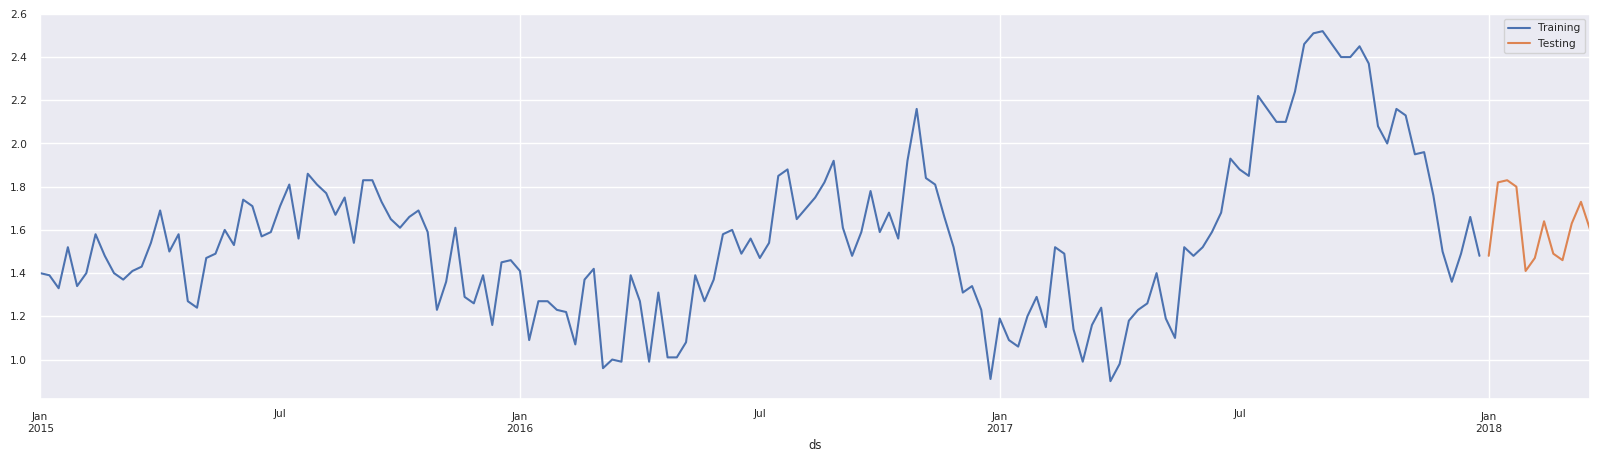

Train shape:  (157, 3)
 Test shape :  (12, 3)


In [ ]:
#Creating the training and the testing datasets of the organic avocado sales in the west region
org_train, org_test = split_data_train_test(organic_pro, train_end_date, True)
# Check the shape of the dataset
print("Train shape: ", org_train.shape)
print(" Test shape : ", org_test.shape)

In [ ]:
organic_pro.describe()

,ds,y,TotalVolume
count,169,169.000000,169.000000
mean,2016-08-14 00:00:00,1.559349,221411.634379
min,2015-01-04 00:00:00,0.900000,96943.410000
25%,2015-10-25 00:00:00,1.330000,166334.970000
50%,2016-08-14 00:00:00,1.520000,203951.840000
75%,2017-06-04 00:00:00,1.750000,252754.610000
max,2018-03-25 00:00:00,2.520000,628445.850000
std,NaN,0.349007,81460.467711


# TASK 5: Training a baseline model for Avocado Prices Forcasting

We will build a univariate baseline model using the default prophet hyperparameters, and fit the model using the training dataset. Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

## 5.1. Case of Organic Avocado

### Fitting the model

In [ ]:

bs_prophet = Prophet()
bs_prophet.fit(org_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/zo_74xld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/ohqurn4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63276', 'data', 'file=/tmp/tmpqquq8fbj/zo_74xld.json', 'init=/tmp/tmpqquq8fbj/ohqurn4j.json', 'output', 'file=/tmp/tmpqquq8fbj/prophet_model93ranfbx/prophet_model-20240515113849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Compute the prediction

**Forcasting into the future**
Make prediction: If you remember that the testing dataset has 12 data points in 2018

In [ ]:
# Create the time range for the forecast
future_baseline = bs_prophet.make_future_dataframe(periods=12, freq="W")
future_baseline.tail()

,ds
164,2018-02-25
165,2018-03-04
166,2018-03-11
167,2018-03-18
168,2018-03-25


In [ ]:
# Make prediction
forecast_baseline = bs_prophet.predict(future_baseline)
forecast_baseline.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.645656,1.147575,1.574876,1.645656,1.645656,-0.274069,-0.274069,-0.274069,-0.274069,-0.274069,-0.274069,0.0,0.0,0.0,1.371586
1,2015-01-11,1.641384,1.140259,1.564703,1.641384,1.641384,-0.284255,-0.284255,-0.284255,-0.284255,-0.284255,-0.284255,0.0,0.0,0.0,1.357129
2,2015-01-18,1.637113,1.142307,1.564105,1.637113,1.637113,-0.286031,-0.286031,-0.286031,-0.286031,-0.286031,-0.286031,0.0,0.0,0.0,1.351082
3,2015-01-25,1.632842,1.154823,1.569733,1.632842,1.632842,-0.271299,-0.271299,-0.271299,-0.271299,-0.271299,-0.271299,0.0,0.0,0.0,1.361542
4,2015-02-01,1.628570,1.167862,1.600117,1.628570,1.628570,-0.233267,-0.233267,-0.233267,-0.233267,-0.233267,-0.233267,0.0,0.0,0.0,1.395303


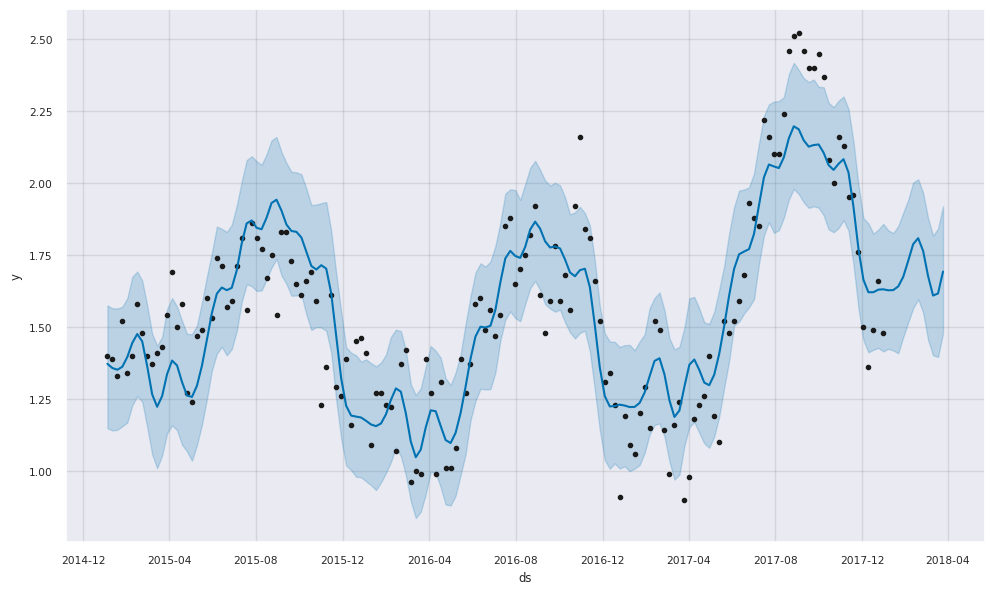

In [ ]:
# Visualize the forecast
bs_prophet.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

*   The black dots are the actual values.
*   The blue line is the prediction.
* The blue shades are the uncertainty interval. The default value for the uncertainty interval is 80%, so we are using 80% here. The uncertainty interval is calculated based on the assumption that the average frequency and magnitude of trend changes in the future will be the same as the historical data. The historical data trend changes are projected forward to get the uncertainty intervals

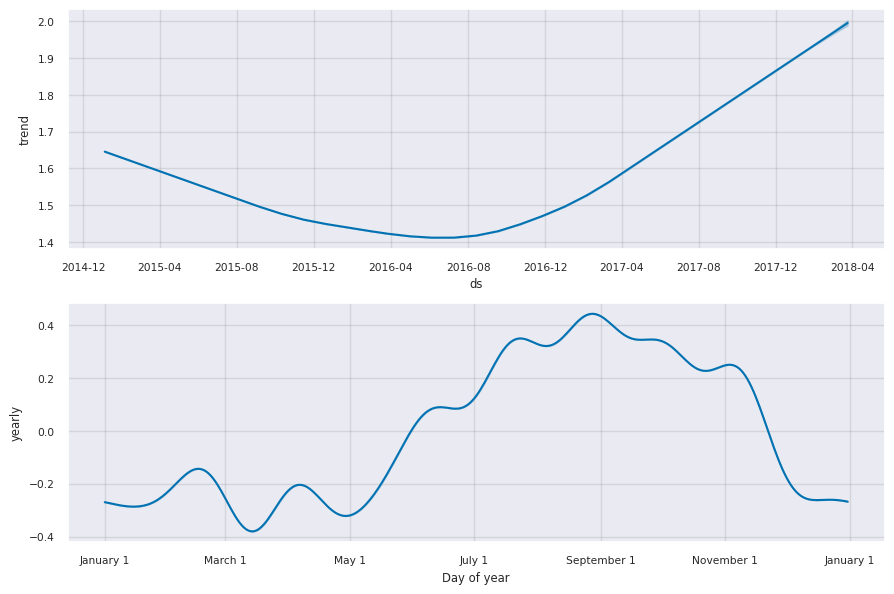

In [ ]:
# Visualize the forecast components
bs_prophet.plot_components(forecast_baseline);

From the component plot chart, we can observe that the price of organic avocados shows an overall upward trend starting in the second half of 2016, following a significant price drop. The yearly seasonality indicates that prices tend to be lower at the beginning of the year and higher in the second half, progressively increasing from May to November, with a peak in August.

### Evaluating of the model

The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the test dataframe to compare the actual values with the predicted values.

In [ ]:
# Merge actual and predicted values (12 latest values)
performance_baseline = pd.merge(org_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:], on='ds')
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 0.18147009397497849
The MAPE for the baseline model is 0.11602607895106788


The mean absolute error (MAE) for the baseline model is 0.18 dollars, meaning that on average, the forecast is off by 0.18 dollars. Given that the average price of organic avocado is 1.56 dollars with std of 0,33 dollars, our prediction is not bad but still should be improved. The mean absolute percent error (MAPE) for the baseline model is 11%, meaning that on average, the forecast is off by 11% of the avocado price.

## 5.2 : Case of Conventional Avocado

### Fitting the model

In [ ]:
conv_pro.describe()

,ds,y,TotalVolume
count,169,169.000000,1.690000e+02
mean,2016-08-14 00:00:00,0.985089,6.209234e+06
min,2015-01-04 00:00:00,0.660000,3.719603e+06
25%,2015-10-25 00:00:00,0.880000,5.413533e+06
50%,2016-08-14 00:00:00,0.960000,6.182298e+06
75%,2017-06-04 00:00:00,1.040000,6.938295e+06
max,2018-03-25 00:00:00,1.620000,1.127475e+07
std,NaN,0.175652,1.186129e+06


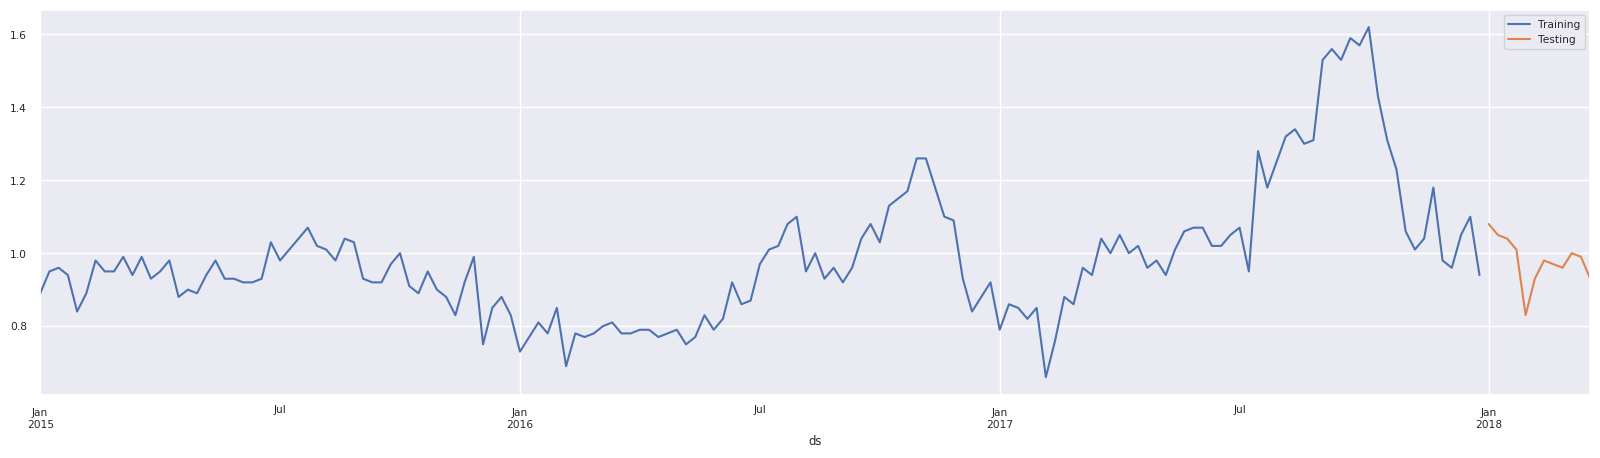

Train shape:  (157, 3)
 Test shape :  (12, 3)


In [ ]:
#Creating the training and the testing datasets of the organic avocado sales in the west region
conv_train, conv_test = split_data_train_test(conv_pro, train_end_date, True)
# Check the shape of the dataset
print("Train shape: ", conv_train.shape)
print(" Test shape : ", conv_test.shape)

In [ ]:
# Add seasonality
model_season = Prophet()
# Fit the model on the training dataset
model_season.fit(conv_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/lv5gvscq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/a2jlq6yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86359', 'data', 'file=/tmp/tmpqquq8fbj/lv5gvscq.json', 'init=/tmp/tmpqquq8fbj/a2jlq6yh.json', 'output', 'file=/tmp/tmpqquq8fbj/prophet_modelvi_m27w3/prophet_model-20240515130157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:01:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:01:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Computing the predictions

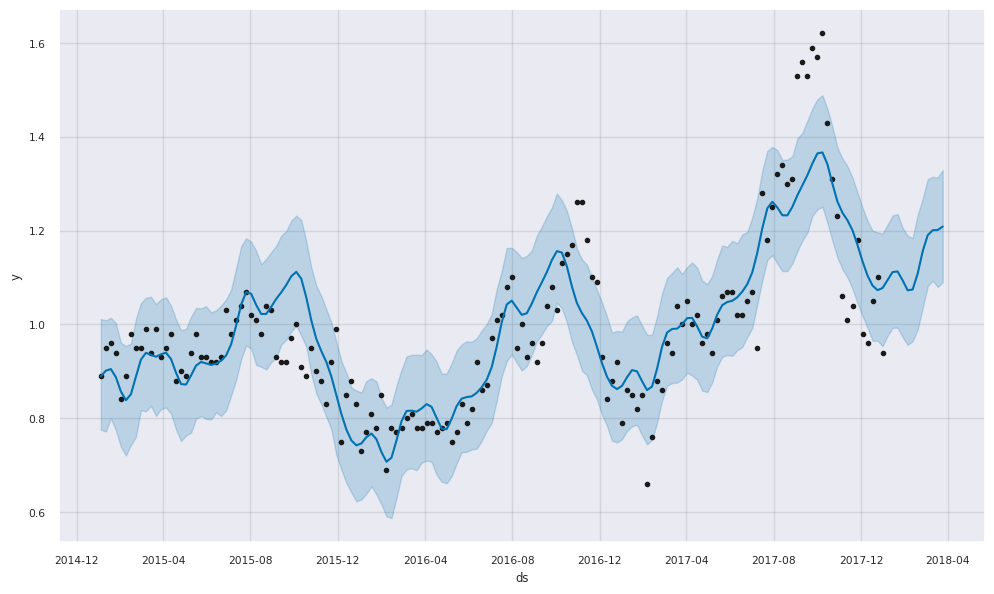

In [ ]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=12, freq="W")
# Make prediction
forecast_season = model_season.predict(future_season)
# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

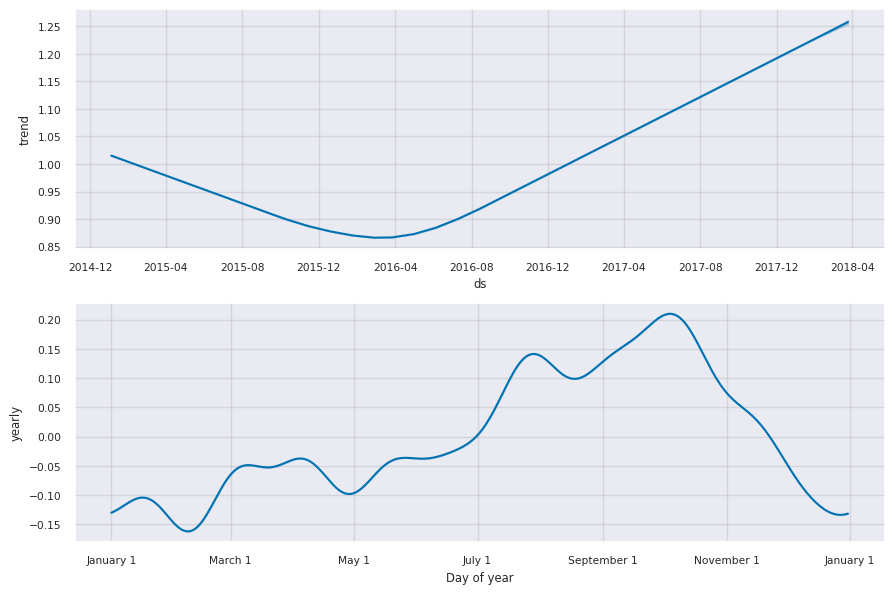

In [ ]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

### Evaluating the model

In [ ]:
# Merge actual and predicted values
performance_season = pd.merge(conv_test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:], on='ds')
# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')
# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 0.15437645670972444
The MAPE for the seasonality model is 0.16220501584721833


# TASK 6 : Mutli-variate Prophet Model for Organic Avocado Prices Forcasting

## 6.1 . Modeling with one additional numerical variable 

### Fitting the model

In [ ]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True)
# Add regressor
model_multivariate.add_regressor('TotalVolume', standardize=False)
# Fit the model on the training dataset
model_multivariate.fit(org_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/nuwu3e02.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/agq_918u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94627', 'data', 'file=/tmp/tmpqquq8fbj/nuwu3e02.json', 'init=/tmp/tmpqquq8fbj/agq_918u.json', 'output', 'file=/tmp/tmpqquq8fbj/prophet_modelmk8xlpqa/prophet_model-20240515132018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Computing the predictions

In [ ]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=12, freq="W")
# Append the regressor values
future_multivariate = pd.merge(future_multivariate, organic_pro[['ds', 'TotalVolume']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
# Check the data
future_multivariate.tail(20)

,ds,TotalVolume
149,2017-11-12,150594.48
150,2017-11-19,152431.73
151,2017-11-26,177222.64
152,2017-12-03,247514.30
153,2017-12-10,313686.31
154,2017-12-17,252754.61
155,2017-12-24,232395.98
156,2017-12-31,229477.07
157,2018-01-07,297190.60
158,2018-01-14,207999.67


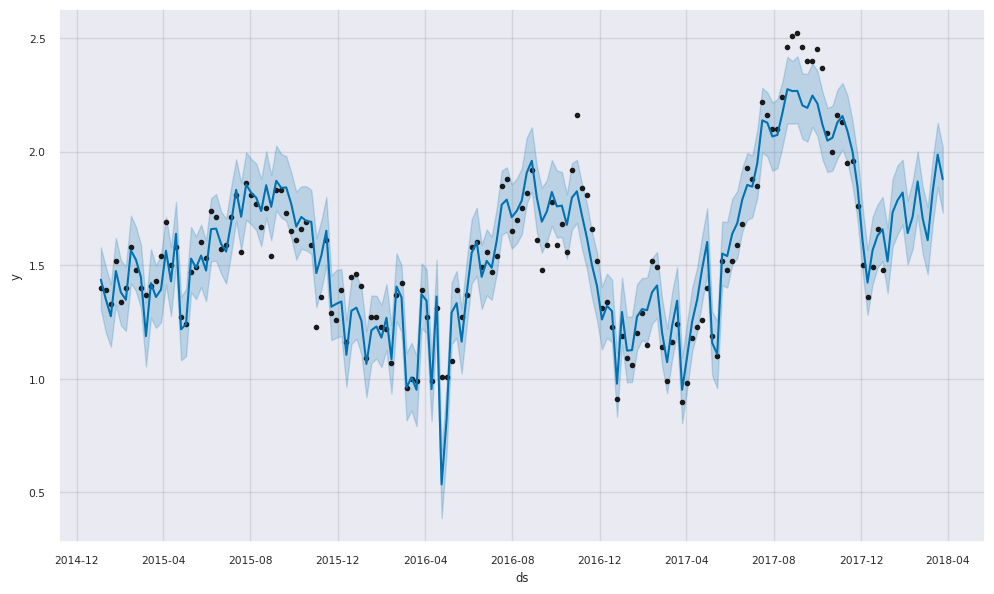

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

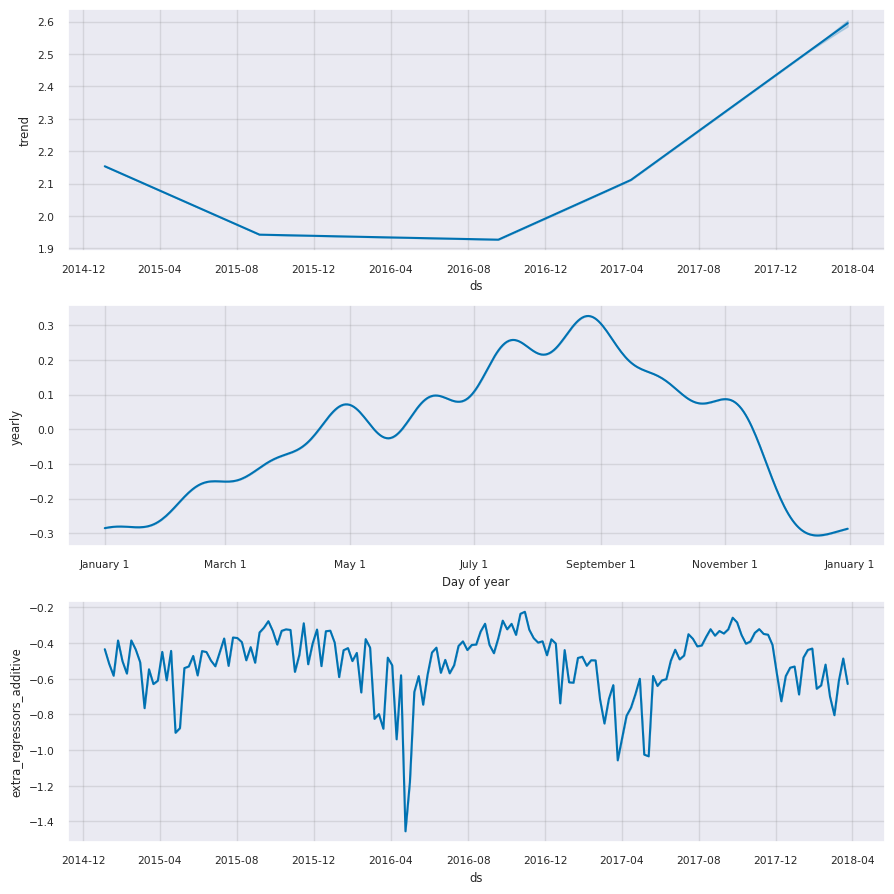

In [ ]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

### Evaluating the model

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(org_test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 0.16564519028467292
The MAPE for the multivariate model is 0.10557635134819736


## 6.2 Modeling with Holydays and Events

### Fitting the model

In [ ]:
# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2015-02-01', '2016-02-07', '2017-02-05', '2018-02-04']),
    'lower_window': -7,
    'upper_window': 2,
})
superbowl

,holiday,ds,lower_window,upper_window
0,superbowl,2015-02-01,-7,2
1,superbowl,2016-02-07,-7,2
2,superbowl,2017-02-05,-7,2
3,superbowl,2018-02-04,-7,2


When initiating the prophet model, the dataframe name *superbowl* is passed to the hyperparameter *holidays*
Prophet has built-in country-specific holidays. We add US holidays to the model using add_country_holidays and setting country_name='US'.


In [ ]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=superbowl)
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')
# Add regressor
model_holiday.add_regressor('TotalVolume', standardize=False)
# Fit the model on the training dataset
model_holiday.fit(org_train)
# All the holidays and events
model_holiday.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/qvrpq39f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/kgrcddjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76181', 'data', 'file=/tmp/tmpqquq8fbj/qvrpq39f.json', 'init=/tmp/tmpqquq8fbj/kgrcddjo.json', 'output', 'file=/tmp/tmpqquq8fbj/prophet_modelilhq5cdj/prophet_model-20240515135848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:58:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

0                       superbowl
1                  New Year's Day
2                    Memorial Day
3                Independence Day
4                       Labor Day
5                    Veterans Day
6                    Thanksgiving
7                   Christmas Day
8        Christmas Day (observed)
9      Martin Luther King Jr. Day
10          Washington's Birthday
11                   Columbus Day
12      New Year's Day (observed)
13        Veterans Day (observed)
14    Independence Day (observed)
dtype: object

### Computing the predictions

In [ ]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=12, freq='W')
# Append the regressor values
future_holiday = pd.merge(future_holiday, organic_pro[['ds', 'TotalVolume']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
future_holiday.tail()

,ds,TotalVolume
0,2015-01-04,187548.30
1,2015-01-11,223156.55
2,2015-01-18,251749.94
3,2015-01-25,166494.38
4,2015-02-01,216484.22


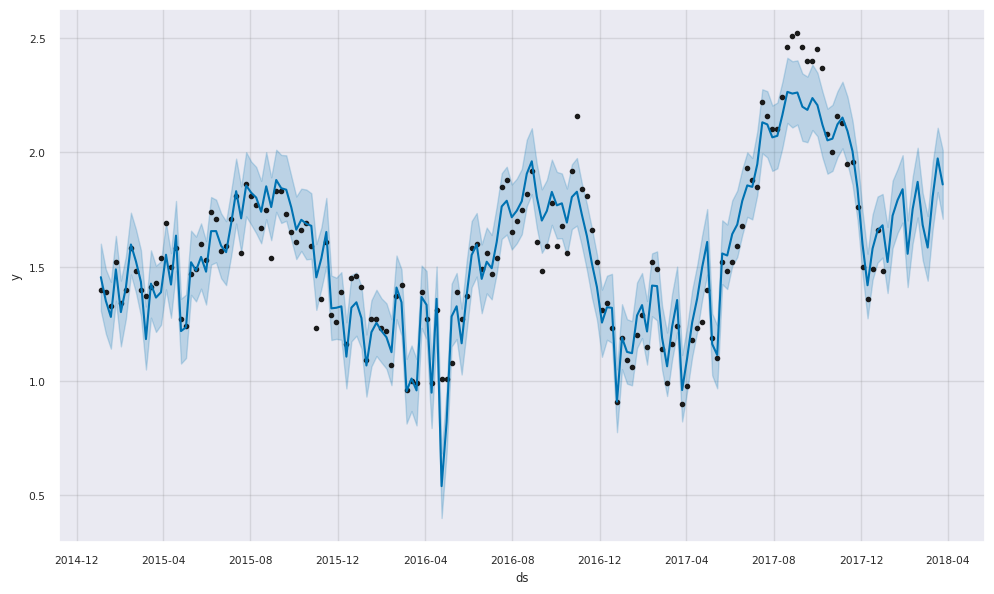

In [ ]:
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

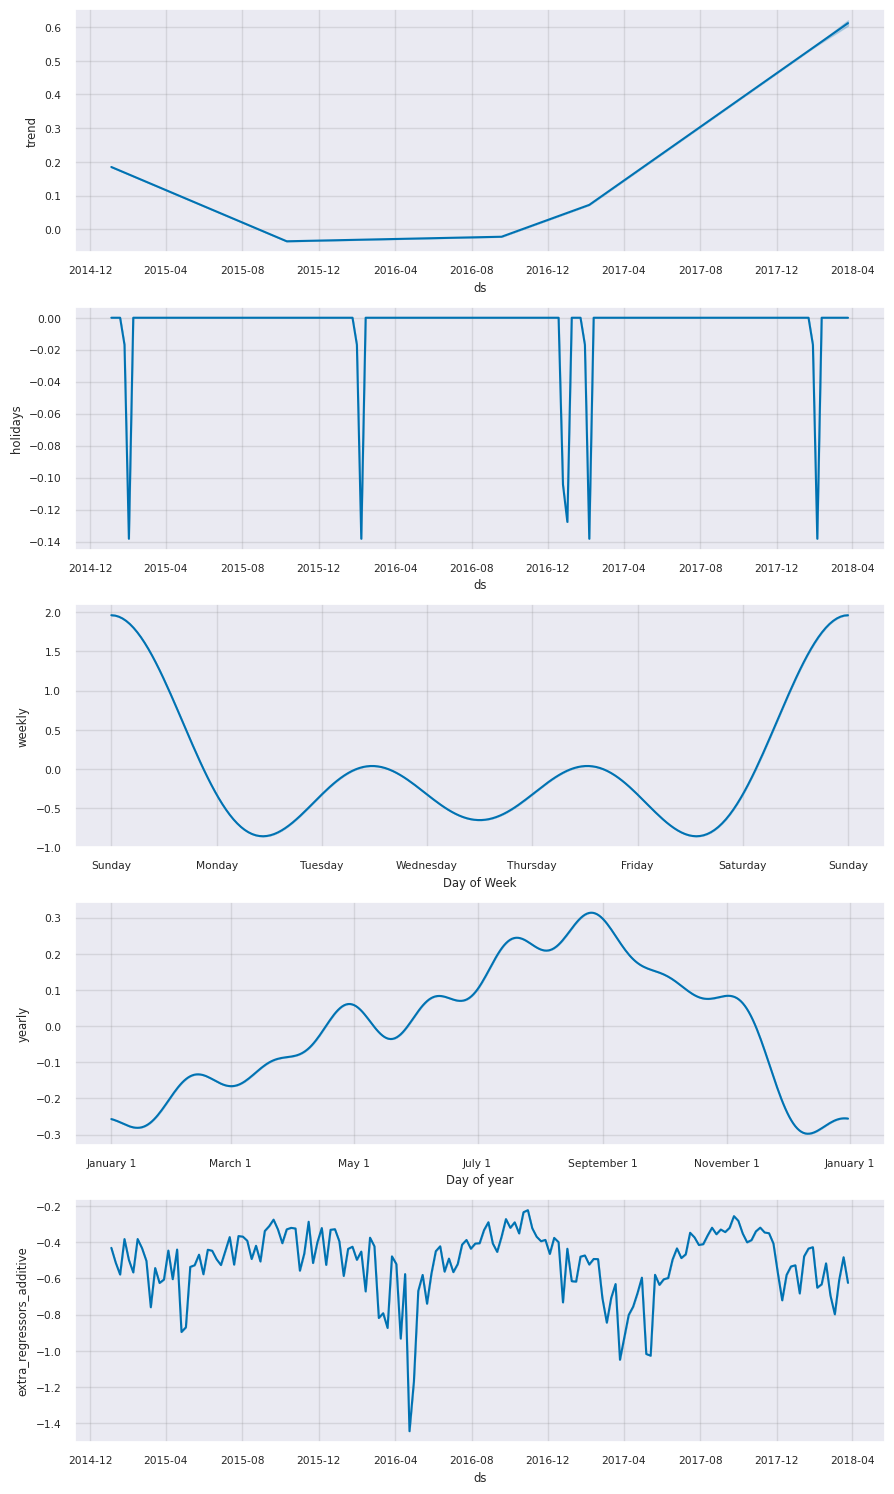

In [ ]:
#Visualise the saisonality components
model_holiday.plot_components(forecast_holiday);

### Evaluating the model

In [ ]:
# Merge actual and predicted values
performance_holiday = pd.merge(org_test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:], on='ds')
print(performance_holiday.head(10))

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')
# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

          ds     y  TotalVolume      yhat  yhat_lower  yhat_upper
0 2018-01-07  1.48    297190.60  1.520692    1.384815    1.674045
1 2018-01-14  1.82    207999.67  1.723255    1.581638    1.876091
2 2018-01-21  1.83    189317.99  1.791612    1.647744    1.927846
3 2018-01-28  1.80    185974.53  1.838786    1.693353    1.987800
4 2018-02-04  1.41    283378.47  1.556498    1.410659    1.702034
5 2018-02-11  1.47    275248.53  1.751644    1.601293    1.892562
6 2018-02-18  1.64    224798.60  1.871009    1.715408    2.020272
7 2018-02-25  1.49    301985.61  1.682753    1.529465    1.821823
8 2018-03-04  1.46    347373.17  1.583931    1.438704    1.721793
9 2018-03-11  1.63    264691.87  1.806333    1.663534    1.956171
The MAE for the holiday/event model is 0.1558270504141697
The MAPE for the holiday/event model is 0.09874928492710681


# Task 7: Multivariate model for conventional avocado using holidays

### Fitting the model

In [ ]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=superbowl)
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')
# Add regressor
model_holiday.add_regressor('TotalVolume', standardize=False)
# Fit the model on the training dataset
model_holiday.fit(conv_train)
# All the holidays and events
model_holiday.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/w165hyun.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqquq8fbj/pdkbi03f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8819', 'data', 'file=/tmp/tmpqquq8fbj/w165hyun.json', 'init=/tmp/tmpqquq8fbj/pdkbi03f.json', 'output', 'file=/tmp/tmpqquq8fbj/prophet_modeli4jhvzmt/prophet_model-20240515135333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:53:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:53:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during p

0                       superbowl
1                  New Year's Day
2                    Memorial Day
3                Independence Day
4                       Labor Day
5                    Veterans Day
6                    Thanksgiving
7                   Christmas Day
8        Christmas Day (observed)
9      Martin Luther King Jr. Day
10          Washington's Birthday
11                   Columbus Day
12      New Year's Day (observed)
13        Veterans Day (observed)
14    Independence Day (observed)
dtype: object

### Computing the predictions

In [ ]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=12, freq='W')
# Append the regressor values
future_holiday = pd.merge(future_holiday, conv_pro[['ds', 'TotalVolume']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
future_holiday.tail()

,ds,TotalVolume
164,2018-02-25,7408451.31
165,2018-03-04,7371498.76
166,2018-03-11,6906412.50
167,2018-03-18,7254940.65
168,2018-03-25,7667064.46


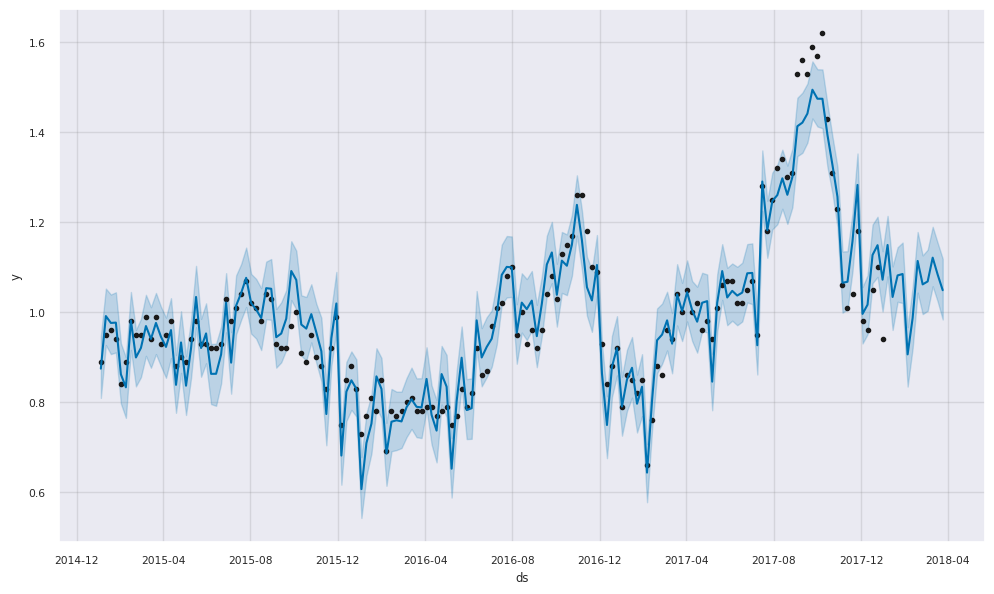

In [ ]:
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

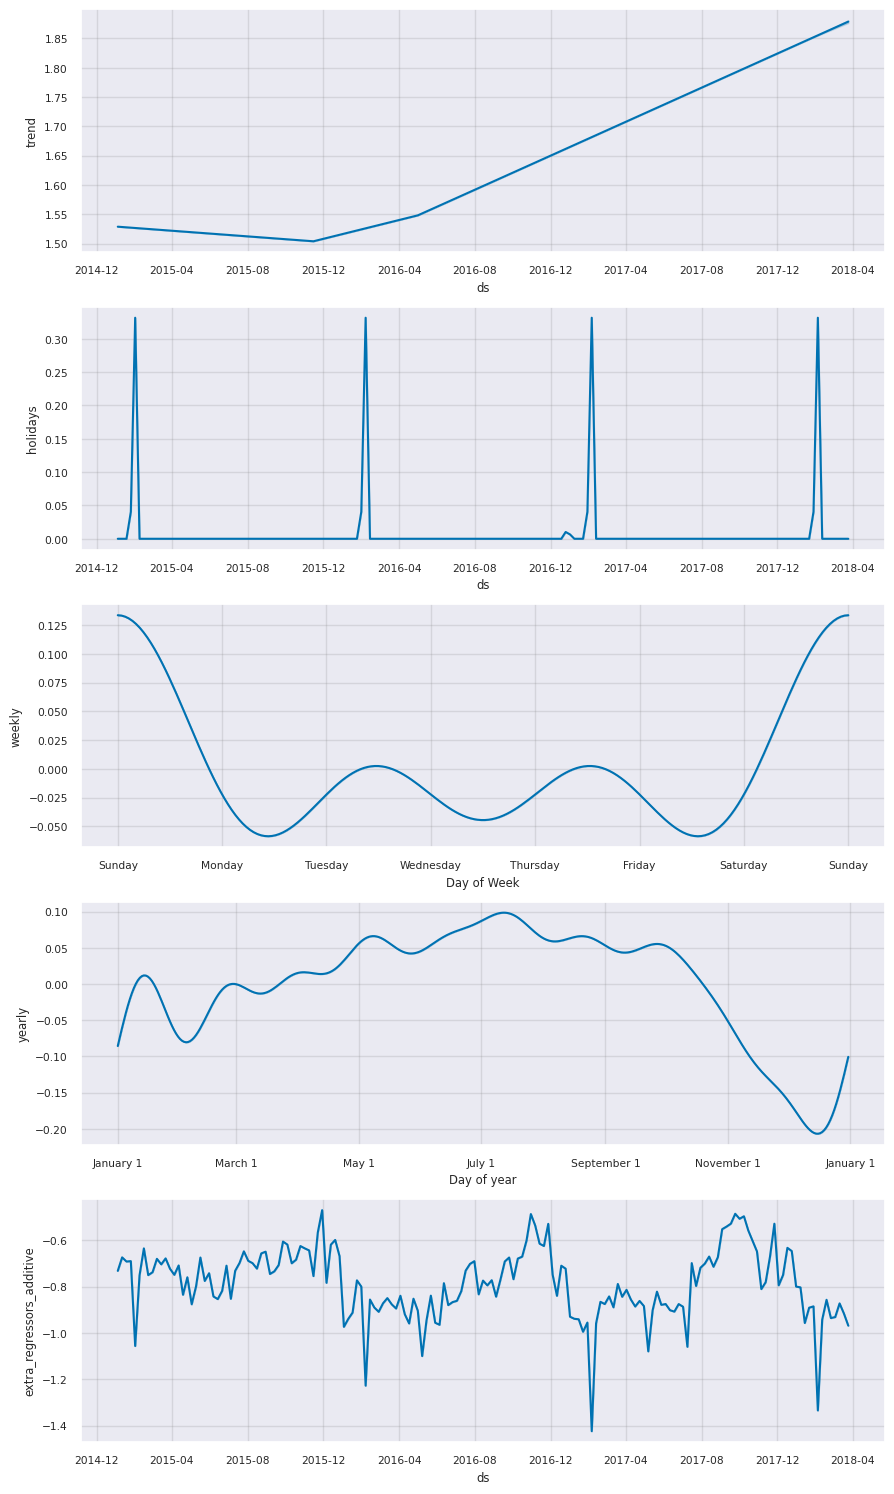

In [ ]:
#Visualise the saisonality components
model_holiday.plot_components(forecast_holiday);

### Evaluating the model

In [ ]:
# Merge actual and predicted values
performance_holiday = pd.merge(conv_test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:], on='ds')
print(performance_holiday.head(10))

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')
# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

          ds     y  TotalVolume      yhat  yhat_lower  yhat_upper
0 2018-01-07  1.08   6358768.95  1.149378    1.079630    1.214162
1 2018-01-14  1.05   7577456.14  1.033796    0.960309    1.101602
2 2018-01-21  1.04   7053820.12  1.081672    1.023037    1.144265
3 2018-01-28  1.01   7007265.31  1.084837    1.020337    1.154769
4 2018-02-04  0.83  10565056.41  0.906069    0.834421    0.966406
5 2018-02-11  0.93   7463494.79  0.987001    0.919869    1.055585
6 2018-02-18  0.98   6783106.02  1.113862    1.043523    1.178275
7 2018-02-25  0.97   7408451.31  1.061740    0.995558    1.126150
8 2018-03-04  0.96   7371498.76  1.068287    1.002944    1.138851
9 2018-03-11  1.00   6906412.50  1.121179    1.057628    1.189846
The MAE for the holiday/event model is 0.08353117755143953
The MAPE for the holiday/event model is 0.08616328693700963
